# Multiobjective optimization

## Main message
Multiobjective optimization is somewhat of a misnomer -- you actually have to have predefined weightings for each of the objectives you care about, or implement them as constraints.

## Context for multiobjective optimization
Most optimization algorithms assume the objective function returns a scalar, thus they are capable of only single-objective optimization. Some other algorithms, including (TODO: add some examples) are able to perform multiobjective optimization in some way. Of course the hope is that you can optimize two or more objective values at once, but the reality is that often those objective functions are at odds with each other.

Let's view aerostructural wing design for an example. In a simple trade-off, if you extend the wingspan you get more lift and aerodynamic performance, but your structural masses and costs become greater to withstand the larger load. This trade-off means that you cannot maximize the aerodynamic performance *and* minimize the structural weight -- there must be some sort of a balancing act. In reality we care about the total performance of the airplane, more than any subdiscipline, so our objective function usually captures effects from multiple disciplines at once.

## Weighted sum method
The simplest way to perform multiobjective optimization is to use the weighted sum method.
The weighted sum method simply combines multiple objective functions by adding them together with some weights on each function.
An example is shown here, 

$$f_{\text{obj}}(x) = \alpha g(x) + \beta h(x)$$

where $g(x)$ and $h(x)$ are two objectives we're trying to optimize simultaneously and $\alpha$ and $\beta$ are weighting variables for each of the objective functions.
If you cared much more about the value of $g(x)$, you would set $\alpha$ to be larger than $\beta$.
However, it's not that simple as $g(x)$ and $h(x)$ might have radically different magnitudes.
If $g(x)$ is on the order 5,000 while $h(x)$ is on the order 0.1, this would cause the optimizer to prioritize changing the design to make $g(x)$ smaller.
An example of this is if we're trying to optimize the structural weight (large magnitude) and the coefficient of drag $C_D$ (small value) for an aircraft:

$$f_{\text{obj}}(x) = f_{\text{structural weight}(x)} [\text{kg}] + f_{C_D}$$

If you care about both objectives approximately equally, you should scale both objective functions by an appropriate amount to make them approximately the same magnitude.
The general form looks like this:

$$f_{\text{obj}}(x) = \alpha \frac{g(x)}{g_0} + \beta \frac{h(x)}{h_0}$$

where $g_0$ and $h_0$ are those magnitude scalars.
In the previously mentioned example, this might look like:

$$f_{\text{obj}}(x) = \alpha \frac{f_{\text{structural weight}(x)} [\text{kg}]}{2700 [\text{kg}]} + \beta \frac{f_{C_D}}{0.025}$$

## A simple multiobjective example

Let's set up a very simple optimization case in OpenMDAO.
This sets up a summation-baed objective function: $f(x) = \alpha g(x) + \beta h(x)$.

In [79]:
import openmdao.api as om
import numpy as np

# build the model
prob = om.Problem()

prob.model.add_subsystem('paraboloid_1', om.ExecComp('g = (x-3)**2'), promotes=['*'])
prob.model.add_subsystem('paraboloid_2', om.ExecComp('h = (x+1)**2 + 3*x'), promotes=['*'])
prob.model.add_subsystem('objective', om.ExecComp('f = alpha * g + beta * h'), promotes=['*'])

# setup the optimization
prob.driver = om.ScipyOptimizeDriver()
prob.driver.options['optimizer'] = 'SLSQP'

prob.model.add_design_var('x', lower=-50, upper=50)
prob.model.add_objective('f')

prob.setup()

# Set initial values.
prob.set_val('x', 3.0)
prob.set_val('alpha', 0.5)  # Vary these values to see different trends
prob.set_val('beta', 0.5)

# run the optimization
prob.run_driver();

print(prob['x'], prob['f'])

Optimization terminated successfully    (Exit mode 0)
            Current function value: 4.9375
            Iterations: 2
            Function evaluations: 3
            Gradient evaluations: 2
Optimization Complete
-----------------------------------
[0.25] [4.9375]


## Pareto front

Pareto fronts (short for frontiers) are a way to visualize a multidimensional design space where you care about multiple objectives. The Pareto front shows the optimal designs for different conditions across multiple objectives. There are infinitely many designs that are suboptimal compared to those along the Pareto front. All designs on the Pareto front come from a completed design optimization.

A design exists on the Pareto front when it cannot be improved in one objective direction without sacrificing performance in the other. In the previous example case, this would mean that along the front, you'd have the lowest possible value of $g(x)$ for a given value of $f(x)$.

There are many designs within this space that are not Pareto optimal, another term for being on the front. Any of those designs are said to be "dominated" by a Pareto front design because an objective value can be improved without sacrificing performance in the other objective.

Pareto fronts can be hyperdimensional, not just two-dimensional. In this example we show only two objective functions to keep the visualization simple.

Now we can sweep through different $\alpha$ and $\beta$ values to create a Pareto front.

In [80]:
x_values = []
f_values = []
g_values = []
h_values = []

alphas = np.linspace(0., 1., 11)

for alpha in alphas:
    prob.set_val('alpha', alpha)# Vary these values to see different trends
    prob.set_val('beta', 1-alpha)

    # run the optimization
    prob.run_driver();

    x_values.append(float(prob["x"]))
    f_values.append(float(prob["f"]))
    g_values.append(float(prob["g"]))
    h_values.append(float(prob["h"]))  

Optimization terminated successfully    (Exit mode 0)
            Current function value: -5.25
            Iterations: 2
            Function evaluations: 3
            Gradient evaluations: 2
Optimization Complete
-----------------------------------
Optimization terminated successfully    (Exit mode 0)
            Current function value: -2.0024999999999995
            Iterations: 2
            Function evaluations: 3
            Gradient evaluations: 2
Optimization Complete
-----------------------------------
Optimization terminated successfully    (Exit mode 0)
            Current function value: 0.6400000000000001
            Iterations: 2
            Function evaluations: 3
            Gradient evaluations: 2
Optimization Complete
-----------------------------------
Optimization terminated successfully    (Exit mode 0)
            Current function value: 2.6775
            Iterations: 2
            Function evaluations: 3
            Gradient evaluations: 2
Optimization Complete


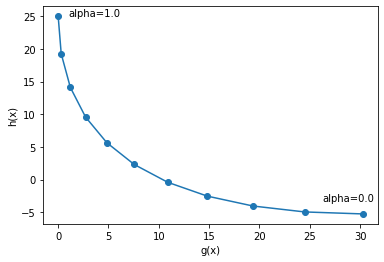

In [81]:
import matplotlib.pyplot as plt

plt.plot(g_values, h_values, marker='o')
plt.xlabel('g(x)')
plt.ylabel('h(x)')

plt.text(g_values[0]-4, h_values[0]+2, f"alpha={alphas[0]}")
plt.text(g_values[-1]+1, h_values[-1], f"alpha={alphas[-1]}")
plt.show()


## Epsilon constraint method

The epsilon-constrained ($\epsilon$-constrained) method is another way to perform multiobjective optimization where one objective function is minimized by the optimizer while the other objective functions are constrained to specific values. This ensures that a given design is optimal is one objective for a given value in the other objective functions.

The $\epsilon$-constrained method is the preferred way to create Pareto fronts because it produces a more robust curve and avoids rare situations where the Pareto front is non-convex that may be troublesome if using the weighted-sum method.

This method also allows you to easily control the spacing for a Pareto front. Given a spread of $g(x)$ values for constraints, you can directly set the spacing produced by a series of optimizations.

For a bi-objective optimization, a good way to know what bounds to use for the constraint values are to run two optimizations first: one unconstrained using the first objective and the other unconstrained with the second objective only. From those two optimizations, the resulting values of the second and first objectives, respectively, could be your constraint limits.

Taking the above plot, we see that $g(x)$ varies between around 0 and 30. Thus, 0 and 30 would be good starting and ending bounds for our sweep of $\epsilon$-constrained optimizations.

In [82]:
x_values_constrained = []
g_values_constrained = []
h_values_constrained = []

g_constraints = np.linspace(0., 30., 21)    

for g_const in g_constraints:
    # build the model
    prob = om.Problem()

    prob.model.add_subsystem('paraboloid_1', om.ExecComp('g = (x-3)**2'), promotes=['*'])
    prob.model.add_subsystem('paraboloid_2', om.ExecComp('h = (x+1)**2 + 3*x'), promotes=['*'])

    # setup the optimization
    prob.driver = om.ScipyOptimizeDriver()
    prob.driver.options['optimizer'] = 'SLSQP'

    prob.model.add_design_var('x', lower=-50, upper=50)
    prob.model.add_constraint('g', equals=g_const)
    prob.model.add_objective('h')

    prob.setup()

    # run the optimization
    prob.run_driver()

    x_values_constrained.append(float(prob["x"]))
    g_values_constrained.append(float(prob["g"]))
    h_values_constrained.append(float(prob["h"]))

Optimization terminated successfully    (Exit mode 0)
            Current function value: 24.999985744700204
            Iterations: 29
            Function evaluations: 45
            Gradient evaluations: 29
Optimization Complete
-----------------------------------
Optimization terminated successfully    (Exit mode 0)
            Current function value: 13.027806414281002
            Iterations: 6
            Function evaluations: 7
            Gradient evaluations: 6
Optimization Complete
-----------------------------------
Optimization terminated successfully    (Exit mode 0)
            Current function value: 8.947441111988304
            Iterations: 5
            Function evaluations: 6
            Gradient evaluations: 5
Optimization Complete
-----------------------------------
Optimization terminated successfully    (Exit mode 0)
            Current function value: 6.165476220827765
            Iterations: 4
            Function evaluations: 4
            Gradient evaluations:

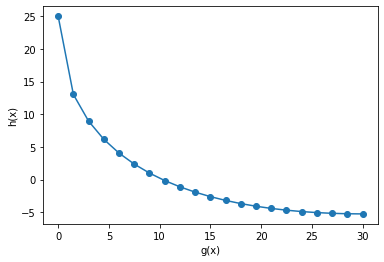

In [83]:
plt.plot(g_values_constrained, h_values_constrained, marker='o')
plt.xlabel('g(x)')
plt.ylabel('h(x)')

plt.show()


You can see in the previous plot that the $g(x)$ values are spaced equally in the plot because we used equally spaced values for the varied constraints.

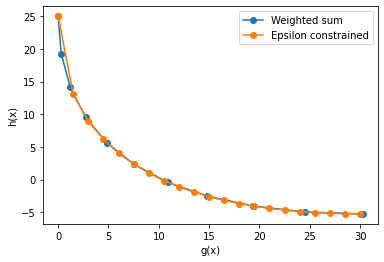

In [84]:
plt.plot(g_values, h_values, marker='o', label='Weighted sum')
plt.plot(g_values_constrained, h_values_constrained, marker='o', label='Epsilon constrained')

plt.legend()
plt.xlabel('g(x)')
plt.ylabel('h(x)')

plt.show()

This last plot shows that the resulting Pareto fronts in this case largely lie on top of each other, as expected. The spacing of optimal points along the two fronts varies based on the method used.